<a href="https://colab.research.google.com/github/NoorFatimaMemon/DeepLearning/blob/main/28_NLP_Basics_and_Embeddings/28_Text_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Text Classification with TensorFlow (SMS Spam)**
## Dataset: UCI SMS Spam Collection
## Task: classify SMS messages as ham (0) or spam (1)

## Imports

In [2]:
import os
import io
import zipfile
import urllib.request
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (7, 4)

# --- Versions / environment info (helpful for debugging) ---
print("TF version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("TF-Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

TF version:  2.19.0
Eager mode:  True
TF-Hub version:  0.16.1
GPU is NOT AVAILABLE


## Download the UCI SMS Spam dataset
* URL: https://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection
* We download a ZIP and read the file inside called "SMSSpamCollection".

In [3]:
uci_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip"

# Download into memory
print("Downloading dataset...")
resp = urllib.request.urlopen(uci_url)
zip_bytes = resp.read()
print("Downloading Completed...")

In [4]:
# Open the zip from memory and extract the data file
with zipfile.ZipFile(io.BytesIO(zip_bytes)) as zf:
    with zf.open("SMSSpamCollection") as f:
        raw = f.read().decode("utf-8")

In [5]:
# Each line is: "<label>\t<message>"
lines = raw.strip().split("\n")
labels, texts = [], []
for line in lines:
    label, text = line.split("\t", 1)  # split only on the first tab
    labels.append(1 if label == "spam" else 0)  # spam->1, ham->0
    texts.append(text)

# Convert to NumPy arrays
texts = np.array(texts, dtype=object)
labels = np.array(labels, dtype=np.int32)

print("Total messages:", len(texts))
print("Spam %: {:.2f}%".format(100.0 * labels.mean()))

Total messages: 5574
Spam %: 13.40%


# Create train / test split
* (The UCI file has no official split, so we make one.)
* We'll do an 80/20 split after shuffling.

In [6]:
rng = np.random.default_rng(seed=42)   # fixed seed for reproducibility
indices = np.arange(len(texts))
rng.shuffle(indices)

texts, labels = texts[indices], labels[indices]
split = int(0.8 * len(texts))          # 80% train, 20% test
train_examples, train_labels = texts[:split], labels[:split]
test_examples, test_labels = texts[split:], labels[split:]
print(f"Training entries: {len(train_examples)}, test entries: {len(test_examples)}")

Training entries: 4459, test entries: 1115


In [7]:
print(train_examples[:5])

['sports fans - get the latest sports news str* 2 ur mobile 1 wk FREE PLUS a FREE TONE Txt SPORT ON to 8007 www.getzed.co.uk 0870141701216+ norm 4txt/120p '
 "It's justbeen overa week since we broke up and already our brains are going to mush!"
 'Not directly behind... Abt 4 rows behind ü...'
 'Haha, my legs and neck are killing me and my amigos are hoping to end the night with a burn, think I could swing by in like an hour?'
 'Me too baby! I promise to treat you well! I bet you will take good care of me...']


In [8]:
print(train_labels[:5])

[1 0 0 0 0]


# Build & Compile (loss/optimizer/metrics) the model
* We use BinaryCrossentropy with from_logits=True because the model outputs raw scores (logits) instead of probabilities.

In [9]:
# hub_url = "https://tfhub.dev/google/nnlm-en-dim50/2"
"""hub_url = "https://tfhub.dev/google/nnlm-en-dim128-with-normalization/2"
hub_layer = hub.KerasLayer(hub_url, dtype=tf.string, trainable=True)

inputs = tf.keras.Input(shape=(), dtype=tf.string)
x = tf.keras.layers.Lambda(lambda text: hub_layer(text), output_shape=(50,))(inputs)
x = tf.keras.layers.Dense(16, activation='relu')(x)
outputs = tf.keras.layers.Dense(1)(x)
model = tf.keras.Model(inputs, outputs)"""

'hub_url = "https://tfhub.dev/google/nnlm-en-dim128-with-normalization/2"\nhub_layer = hub.KerasLayer(hub_url, dtype=tf.string, trainable=True)\n\ninputs = tf.keras.Input(shape=(), dtype=tf.string)\nx = tf.keras.layers.Lambda(lambda text: hub_layer(text), output_shape=(50,))(inputs)\nx = tf.keras.layers.Dense(16, activation=\'relu\')(x)\noutputs = tf.keras.layers.Dense(1)(x)\nmodel = tf.keras.Model(inputs, outputs)'

In [10]:
hub_url = "https://tfhub.dev/google/nnlm-en-dim128-with-normalization/2"

# Create a custom Keras Layer to wrap the hub_layer
class HubLayerWrapper(tf.keras.layers.Layer):
    def __init__(self, hub_url, **kwargs):
        super(HubLayerWrapper, self).__init__(**kwargs)
        self.hub_layer = hub.KerasLayer(hub_url, dtype=tf.string, trainable=True)

    def call(self, inputs):
        # Explicitly place the hub_layer call on the CPU
        with tf.device('/CPU:0'):
            return self.hub_layer(inputs)

# Instantiate the custom layer
wrapped_hub_layer = HubLayerWrapper(hub_url)

inputs = tf.keras.Input(shape=(), dtype=tf.string)
x = wrapped_hub_layer(inputs) # Use the wrapped layer
x = tf.keras.layers.Dense(16, activation='relu')(x)
outputs = tf.keras.layers.Dense(1)(x)
model = tf.keras.Model(inputs, outputs)
model.compile(optimizer='adam', loss=tf.losses.BinaryCrossentropy(from_logits=True),
              metrics=[tf.metrics.BinaryAccuracy(threshold=0.0, name='accuracy')])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None)                 │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hub_layer_wrapper               │ (None, 128)            │             0 │
│ (HubLayerWrapper)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │         2,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,081 (8.13 KB)

 Trainable params: 2,081 (8.13 KB)

 Non-trainable params: 0 (0.00 B)

# Create a validation set from the training data
* We'll hold out the first 1,000 examples for validation.
* (Training and validation must come ONLY from the training split.)

In [11]:
val_size = 1000 if len(train_examples) > 1000 else max(1, len(train_examples)//5)

x_val = train_examples[:val_size]
partial_x_train = train_examples[val_size:]

y_val = train_labels[:val_size]
partial_y_train = train_labels[val_size:]

print(f"Train size (used for fitting): {len(partial_x_train)}")
print(f"Validation size: {len(x_val)}")
print(f"Test size: {len(test_examples)}")

Train size (used for fitting): 3459
Validation size: 1000
Test size: 1115


# Train the model

In [12]:
# Explicitly train on the CPU
with tf.device('/CPU:0'):
    history = model.fit(partial_x_train, partial_y_train, epochs=40, batch_size=512, validation_data=(x_val, y_val), verbose=1)

Epoch 1/40
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - accuracy: 0.1926 - loss: 0.7479 - val_accuracy: 0.4320 - val_loss: 0.7030
Epoch 2/40
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.5685 - loss: 0.6867 - val_accuracy: 0.7930 - val_loss: 0.6474
Epoch 3/40
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8283 - loss: 0.6343 - val_accuracy: 0.8640 - val_loss: 0.6012
Epoch 4/40
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.8673 - loss: 0.5898 - val_accuracy: 0.8760 - val_loss: 0.5620
Epoch 5/40
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8718 - loss: 0.5562 - val_accuracy: 0.8770 - val_loss: 0.5275
Epoch 6/40
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8736 - loss: 0.5213 - val_accuracy: 0.8780 - val_loss: 0.4966
Epoch 7/40
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8700 - loss: 0.4950 - val_accuracy: 0.8790 - val_loss: 0.4689
Epoch 8/40
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8653 - loss: 0.4715 - val_accuracy: 0.8810 - val_loss: 0.4439


# Evaluate on the test set

In [13]:
results = model.evaluate(test_examples, test_labels, verbose=0)
print("Test Loss, Test Accuracy:", results)

Test Loss, Test Accuracy: [0.12903840839862823, 0.9623318314552307]


# Plot training vs validation loss and accuracy

In [14]:
history_dict = history.history
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc)+1)

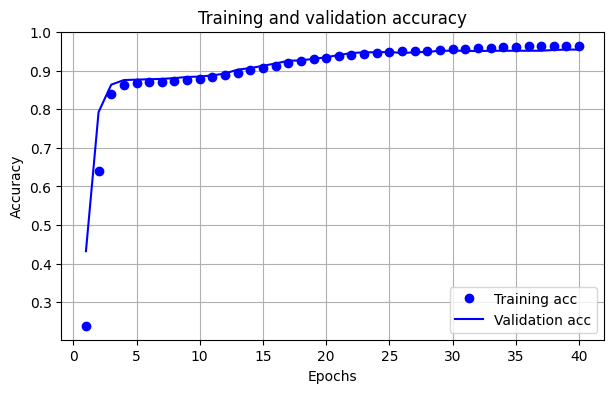

In [17]:
# Plot Accuracy
plt.plot(epochs, acc, 'bo', label='Training acc')     # blue dots
plt.plot(epochs, val_acc, 'b', label='Validation acc')  # blue line
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

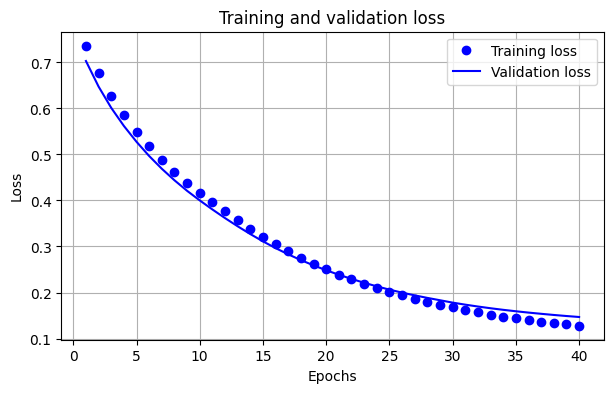

In [18]:
# Plot Loss
plt.plot(epochs, loss, 'bo', label='Training loss')   # blue dots
plt.plot(epochs, val_loss, 'b', label='Validation loss')  # blue line
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()